In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
with open('/content/drive/MyDrive/Colab Notebooks/PClub - SecyRecr/Copy of adjacency_matrices.csv', 'r') as f:
  lines = f.readlines()

data = [list(map(int, line.strip().split(','))) for line in lines[1:]]

In [3]:
max_len = max(len(row) for row in data)
padded_data = np.array([row[1:] + [0] * (max_len - len(row)) for row in data])
padded_data

array([[5, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       ...,
       [6, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0]])

In [4]:
df = pd.DataFrame(padded_data)
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
496,7,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
497,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,6,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
images = np.zeros((500, 757, 727))

for i in range(500):
  img_path = f'/content/drive/MyDrive/Colab Notebooks/PClub - SecyRecr/graph_images/graph_{i}.png'
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  images[i] = img

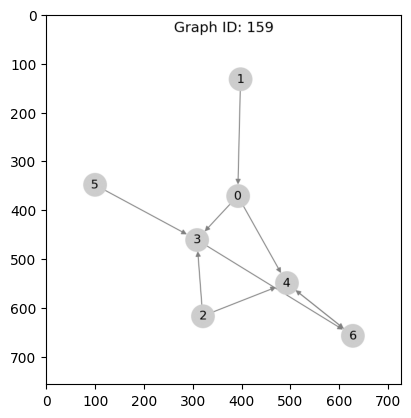

In [11]:
plt.imshow(images[np.random.randint(500)], cmap='gray')

In [5]:
!pip install pytesseract

In [6]:
import pytesseract

In [ ]:
allCircles = [[] for _ in range(500)]
allLines = [[] for _ in range(500)]
allHeads = [[] for _ in range(500)]

for i in range(500):
    imgtest = images[i].astype(np.uint8)

    circles = cv2.HoughCircles(imgtest, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=20, minRadius=20, maxRadius=30)

    blurred = cv2.GaussianBlur(imgtest, (9, 9), 50)
    heads = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=5, minRadius=2, maxRadius=5)

    edges = cv2.Canny(imgtest, 20, 80)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=10, maxLineGap=10)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for (x, y, r) in circles[0, :]:
            x, y, r = int(x), int(y), int(r)
            x1 = max(0, x - r)
            x2 = min(imgtest.shape[1], x + r)
            y1 = max(0, y - r)
            y2 = min(imgtest.shape[0], y + r)
            roi = imgtest[y1:y2, x1:x2]
            _, thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            config = '--psm 10 -c tessedit_char_whitelist=0123456789'
            text = pytesseract.image_to_string(thresh, config=config)
            number = ''.join(filter(str.isdigit, text))
            if number:
                allCircles[i].append((x, y, r, int(number[0])))
            else:
                allCircles[i].append((x, y, r, -1))

    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        keep = True
        for f_line in filtered_lines:
            fx1, fy1, fx2, fy2 = f_line[0]
            dist_start = ((x1 - fx1)**2 + (y1 - fy1)**2)**0.5
            dist_end = ((x2 - fx2)**2 + (y2 - fy2)**2)**0.5
            if dist_start < 10 or dist_end < 10:
                keep = False
                break
        if keep:
            filtered_lines.append(line)

    if filtered_lines is not None:
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            allLines[i].append((int(x1), int(y1), int(x2), int(y2)))

    if heads is not None:
        heads = np.uint16(np.around(heads))
        for (x, y, r) in heads[0, :]:
            allHeads[i].append((int(x), int(y)))

    print(i)

In [42]:
c = 0

for i in range(500):
    n = len(allCircles[i])
    for j in range(n):
        allCircles[i][j] = list(allCircles[i][j])
        if(allCircles[i][j][3] == -1):
            c += 1
            s = 0
            for k in range(n):
                if(allCircles[i][k][3] != -1):
                    s += allCircles[i][k][3]
            allCircles[i][j][3] = n*(n-1)/2 - s
    for j in range(len(allLines[i])):
        allLines[i][j] = list(allLines[i][j])
    for j in range(len(allHeads[i])):
        allHeads[i][j] = list(allHeads[i][j])

print(c)

38


In [43]:
lencircles = max(len(row) for row in allCircles)
lenlines = max(len(row) for row in allLines)
lenheads = max(len(row) for row in allHeads)

print(lencircles)
print(lenlines)
print(lenheads)

7
42
32


In [44]:
for i in range(500):
    for _ in range(lencircles - len(allCircles[i])):
        allCircles[i].append([-757, -757, -757, -757])
    for _ in range(lenlines - len(allLines[i])):
        allLines[i].append([-757, -757, -757, -757])
    for _ in range(lenheads - len(allHeads[i])):
        allHeads[i].append([-757, -757])

In [45]:
allCirclesarr = np.array(allCircles, dtype=np.float32)
allLinesarr = np.array(allLines, dtype=np.float32)
allHeadsarr = np.array(allHeads, dtype=np.float32)

print(allCirclesarr.shape)
print(allLinesarr.shape)
print(allHeadsarr.shape)

(500, 7, 4)
(500, 42, 4)
(500, 32, 2)


In [46]:
for i in range(500):
    for j in range(7):
        allCirclesarr[i][j][0] = allCirclesarr[i][j][0] / 757
        allCircles[i][j][1] = allCircles[i][j][1] / 757
        allCircles[i][j][2] = allCircles[i][j][2] / 727
    for j in range(42):
        allLinesarr[i][j] = allLinesarr[i][j] / 757
    for j in range(32):
        allHeadsarr[i][j] = allHeadsarr[i][j] / 757

In [61]:
X = np.concatenate((allCirclesarr, allLinesarr, np.pad(allHeadsarr, ((0, 0), (0, 0), (0, 2)), constant_values=-1)), axis=1)
y = np.array(df.drop(columns=[0]))
print(X.shape)
print(y.shape)

(500, 81, 4)
(500, 49)


In [31]:
import torch
import torch.nn as nn

In [52]:
model = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 81, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 49)
)

In [63]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [65]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(y, dtype=torch.float32)

In [66]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from torch.utils.data import Subset
import numpy as np

for epoch in range(200):
    indices = np.random.permutation(len(X_tensor))
    val_size = int(0.2 * len(X_tensor))

    val_idx = indices[:val_size]
    train_idx = indices[val_size:]

    train_loader = DataLoader(Subset(TensorDataset(X_tensor, Y_tensor), train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(TensorDataset(X_tensor, Y_tensor), val_idx), batch_size=32)

    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_outputs = model(val_x)
            v_loss = criterion(val_outputs, val_y)
            val_loss += v_loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}")


In [68]:
with torch.no_grad():
    preds = model(X_tensor)
    preds_binary = (torch.sigmoid(preds) > 0.5).int()

In [ ]:
preds_binary

In [70]:
torch.save(model, 'model.pth')